In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import h5py
import copy

import amici
from petab.C import *
import petab
import petab.C
import pypesto
import pypesto.petab
from pypesto.optimize import minimize
from pypesto.startpoint import uniform
from pypesto.engine import MultiProcessEngine, MultiThreadEngine
from pypesto.optimize.optimizer import FidesOptimizer
import pypesto.optimize as optimize

from pypesto.visualize import waterfall
from pypesto.visualize import parameters
from pypesto.visualize.model_fit import visualize_optimized_model_fit
from pypesto.visualize import profiles

import pypesto.profile as profile
from pypesto.optimize import ScipyOptimizer
from pypesto.profile.options import ProfileOptions

from pypesto.visualize.model_fit import visualize_optimized_model_fit, _get_simulation_rdatas

In [2]:
def hex_to_rgba_gradient(color1, color2, n):
    '''
    Create a gradient in rgba between two hex colors
    '''
    # Convert to rgba
    c1 = matplotlib.colors.to_rgba(matplotlib.colors.hex2color(color1))
    c2 = matplotlib.colors.to_rgba(matplotlib.colors.hex2color(color2))

    return [[(c1[i]*(n-j-1) + c2[i]*j)/(n-1) for i in range(4)] for j in range(n)]

# find the index for cut off based on Chi square distribution CI 95%
def find_cut_off_index(result, ci = 0.95):
    '''
    Find the cut off index for the data based on the Chi square distribution
    '''

    # calculate the chi square distribution
    cut_off_value = scipy.stats.chi2.ppf(ci, 1)

    # find the index
    best_fval = result.optimize_result.list[0].fval

    for i in range(len(result.optimize_result.list)):
        if result.optimize_result.list[i].fval > best_fval + cut_off_value:
            break
    
    return i - 1

def find_cut_off_x_trace(result, ci = 0.95, flatten = True):

    cut_off_value = scipy.stats.chi2.ppf(ci, 1)
    best_fval = result.optimize_result.list[0].fval

    # store the optimized x trace that are below the cut off value
    x_trace_within_cut_off = []
    if flatten:
        for i in range(find_cut_off_index(result, ci)):
            
            fval_trace = result.optimize_result.list[i].history.get_fval_trace()
            x_trace = result.optimize_result.list[i].history.get_x_trace()

            for j in range(len(fval_trace)):
                if fval_trace[j] < best_fval + cut_off_value:
                    x_trace_within_cut_off.append(x_trace[j])
    else:
        for i in range(find_cut_off_index(result, ci)):
            
            fval_trace = result.optimize_result.list[i].history.get_fval_trace()
            x_trace = result.optimize_result.list[i].history.get_x_trace()

            x_trace_within_cut_off_i = []
            for j in range(len(fval_trace)):
                if fval_trace[j] < best_fval + cut_off_value:
                    x_trace_within_cut_off_i.append(x_trace[j])
            x_trace_within_cut_off.append(x_trace_within_cut_off_i)

    return x_trace_within_cut_off

In [3]:
# Plot setting
plt.rcParams['font.size'] = 30

dpi = 100
wid = int(2560/dpi)
hei = int(1600/dpi)

In [4]:
# number of optimization runs
n_runs = 5000

In [5]:
# Define the folder where you want to save the figures
folder_path = "/Users/yuhongliu/Documents/OV/figures/first_model/n"+str(n_runs)+"/"

# If the folder does not exist, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# optimization
hierarchical = True

petab_yaml = 'petab_files/init_model.yaml'
petab.validate(petab_yaml)
petab_problem = petab.Problem.from_yaml(petab_yaml)

np.random.seed(500)

problem = pypesto.petab.PetabImporter(
        petab_problem,
        hierarchical=hierarchical,
        model_name=f"INIT_Model",
    ).create_problem(force_compile=True)

# some model properties
print("Model parameters:", list(problem.objective.amici_model.getParameterIds()), "\n")
print("Model const parameters:", list(problem.objective.amici_model.getFixedParameterIds()), "\n")
print("Model outputs:   ", list(problem.objective.amici_model.getObservableIds()), "\n")
print("Model states:    ", list(problem.objective.amici_model.getStateIds()), "\n")

Compiling amici model to folder /Users/yuhongliu/Documents/OV/models/first_model/amici_models/0.26.1/INIT_Model.
2024-09-13 15:39:43.141 - amici.petab.sbml_import - INFO - Importing model ...
2024-09-13 15:39:43.141 - amici.petab.sbml_import - INFO - Validating PEtab problem ...
2024-09-13 15:39:43.150 - amici.petab.sbml_import - INFO - Model name is 'INIT_Model'.
Writing model code to '/Users/yuhongliu/Documents/OV/models/first_model/amici_models/0.26.1/INIT_Model'.
2024-09-13 15:39:43.150 - amici.petab.sbml_import - INFO - Species: 0
2024-09-13 15:39:43.150 - amici.petab.sbml_import - INFO - Global parameters: 11
2024-09-13 15:39:43.150 - amici.petab.sbml_import - INFO - Reactions: 0
2024-09-13 15:39:43.159 - amici.petab.sbml_import - INFO - Observables: 1
2024-09-13 15:39:43.159 - amici.petab.sbml_import - INFO - Sigmas: 1
2024-09-13 15:39:43.160 - amici.petab.sbml_import - DEBUG - Adding output parameters to model: ['observableParameter1_tumor_vol', 'noiseParameter1_tumor_vol']
202

running build_ext
running AmiciBuildCMakeExtension
------------------------------ model_ext ------------------------------

==> Configuring:
$ cmake -S /Users/yuhongliu/Documents/OV/models/first_model/amici_models/0.26.1/INIT_Model -B /Users/yuhongliu/Documents/OV/models/first_model/amici_models/0.26.1/INIT_Model/build_model_ext -G Ninja -DCMAKE_MAKE_PROGRAM=/opt/homebrew/bin/ninja -DCMAKE_BUILD_TYPE=Release -DCMAKE_INSTALL_PREFIX:PATH=/Users/yuhongliu/Documents/OV/models/first_model/amici_models/0.26.1/INIT_Model/INIT_Model -DCMAKE_VERBOSE_MAKEFILE=ON -DCMAKE_MODULE_PATH=/opt/homebrew/lib/python3.12/site-packages/amici/lib/cmake/SuiteSparse;/opt/homebrew/lib/python3.12/site-packages/amici/lib64/cmake/SuiteSparse -DKLU_ROOT=/opt/homebrew/lib/python3.12/site-packages/amici -DAMICI_PYTHON_BUILD_EXT_ONLY=ON -DPython3_EXECUTABLE=/opt/homebrew/opt/python@3.12/bin/python3.12

==> Building:
$ cmake --build /Users/yuhongliu/Documents/OV/models/first_model/amici_models/0.26.1/INIT_Model/build_m

2024-09-13 15:39:52.318 - amici.petab.sbml_import - INFO - Finished Importing PEtab model            (9.18E+00s)


Model parameters: ['rho', 'kappa', 'psi_1', 'alpha', 'beta', 'psi_2', 'delta', 'observableParameter1_tumor_vol', 'noiseParameter1_tumor_vol'] 

Model const parameters: ['virus_injection'] 

Model outputs:    ['tumor_vol'] 

Model states:     ['C_u', 'C_i', 'V'] 



In [6]:
loading = True

if loading:
    # load result history from file
    result = pypesto.store.read_result('optimization_history/n'+ str(n_runs) +'.hdf5')

else:
    # optimize the model
    result = minimize(
        problem=problem,
        optimizer=FidesOptimizer(verbose=False, options={'maxiter': 5000}),
        n_starts=n_runs,
        engine=MultiProcessEngine(),
        # startpoint_method=uniform,
        history_options = pypesto.HistoryOptions(trace_record=True, storage_file='optimization_history/n'+ str(n_runs) +'.hdf5'),
        filename='optimization_history/n'+ str(n_runs) +'.hdf5',
    )

# print result summary
print(result.summary())

Loading the profiling result failed. It is highly likely that no profiling result exists within optimization_history/n5000.hdf5.
Loading the sampling result failed. It is highly likely that no sampling result exists within optimization_history/n5000.hdf5.


## Optimization Result 

* number of starts: 5000 
* best value: 1552.739046402772, id=2
* worst value: inf, id=997
* number of non-finite values: 666

* execution time summary:
	* Mean execution time: 0.869s
	* Maximum execution time: 119.661s,	id=533
	* Minimum execution time: 0.008s,	id=995
* summary of optimizer messages:

  |   Count | Message                                                     |
  |--------:|:------------------------------------------------------------|
  |    3209 | Converged according to fval difference                      |
  |     920 | Converged according to gradient norm                        |
  |     666 | Encountered non-finite function inf value at initial point. |
  |     205 | Trust Region Radius too small to proceed                    |

* best value found (approximately) 1 time(s)
* number of plateaus found: 37

A summary of the best run:

### Optimizer Result

* optimizer used: <FidesOptimizer  hessian_update=default verbose=False options={'maxit

# Obtain data and visualize the fitting result

In [7]:
return_dict = problem.objective(result.optimize_result.list[0].x, return_dict=True)
rdatas = return_dict['rdatas']
edatas = problem.objective.edatas
x_axis = [edata.id for edata in edatas]
simulation = [rdata.y.reshape(5, -1)[:,0] for rdata in rdatas]
data = [np.array(edata.getObservedData()).reshape(5, -1) for edata in edatas]

In [8]:
parameters_from_result = dict(zip(problem.x_names, result.optimize_result.list[0]['x']))

In [9]:
parameters_from_result

{'rho': np.float64(2.125425479769065),
 'kappa': np.float64(-3.322577141485921),
 'psi_1': np.float64(-1.9551014607702855),
 'psi_2': np.float64(0.47284580478975397),
 'beta': np.float64(1.5292570522507192),
 'alpha': np.float64(-0.6454798833044904),
 'delta': np.float64(0.9593363460014531)}

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2t/ydbb2dx16f3_f00v2ldb8_8m0000gn/T/ipykernel_69350/4285206874.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Tumor Volume ($\mu m^3$)')


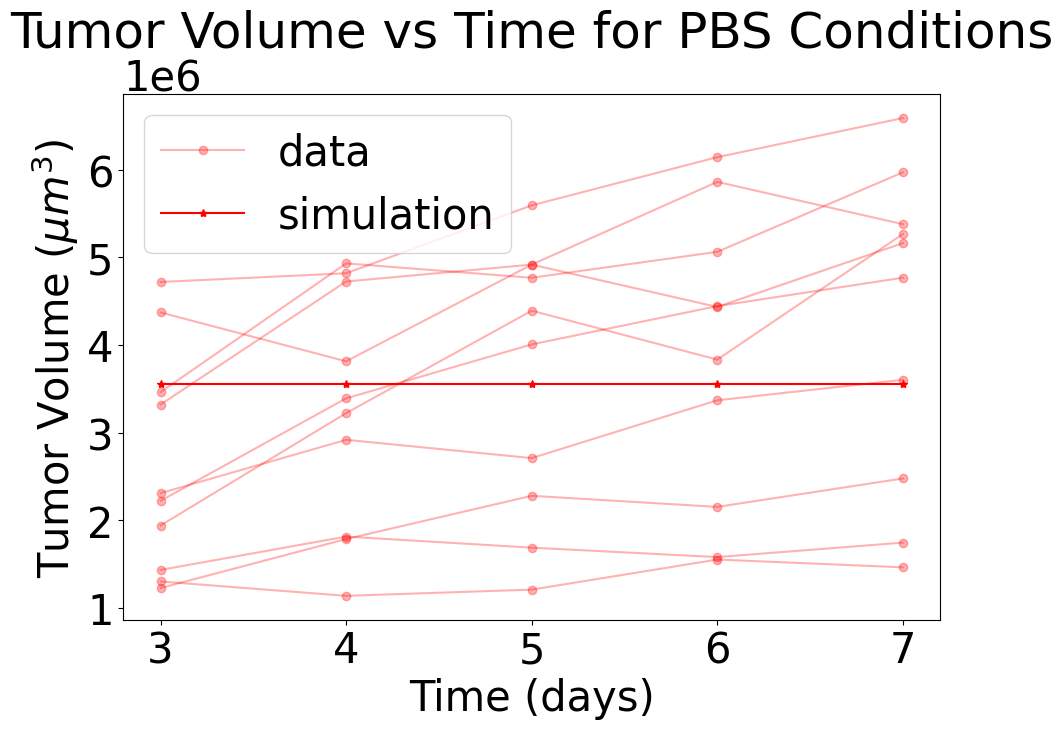

In [10]:
# visualize the fitting result by comparing the simulation and the data
# separate into vvDD and ctrl with two subplots

# plot the ctrl data and simulation, simulation[0] (1d array) and data[0] 
# (2d array as it has 5 timepoints [3,4,5,6,7] and 10 samples)
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.plot(np.array([3,4,5,6,7]), data[0][:, i], 
             marker='o', linestyle='-', color='red', alpha=0.3, label='data' if i == 0 else "")
plt.plot(np.array([3,4,5,6,7]), simulation[0], 
         marker='*', linestyle='-', color='red', alpha=1, label='simulation')
plt.xlabel('Time (days)')
plt.ylabel('Tumor Volume ($\mu m^3$)')
plt.title('Tumor Volume vs Time for PBS Conditions')
plt.legend()
plt.grid(False)
plt.xticks([3, 4, 5, 6, 7])
plt.tight_layout()
plt.savefig(folder_path + 'ctrl_fit.pdf', dpi=300, bbox_inches='tight')
plt.show()


<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2t/ydbb2dx16f3_f00v2ldb8_8m0000gn/T/ipykernel_69350/3021803029.py:10: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Tumor Volume ($\mu m^3$)')


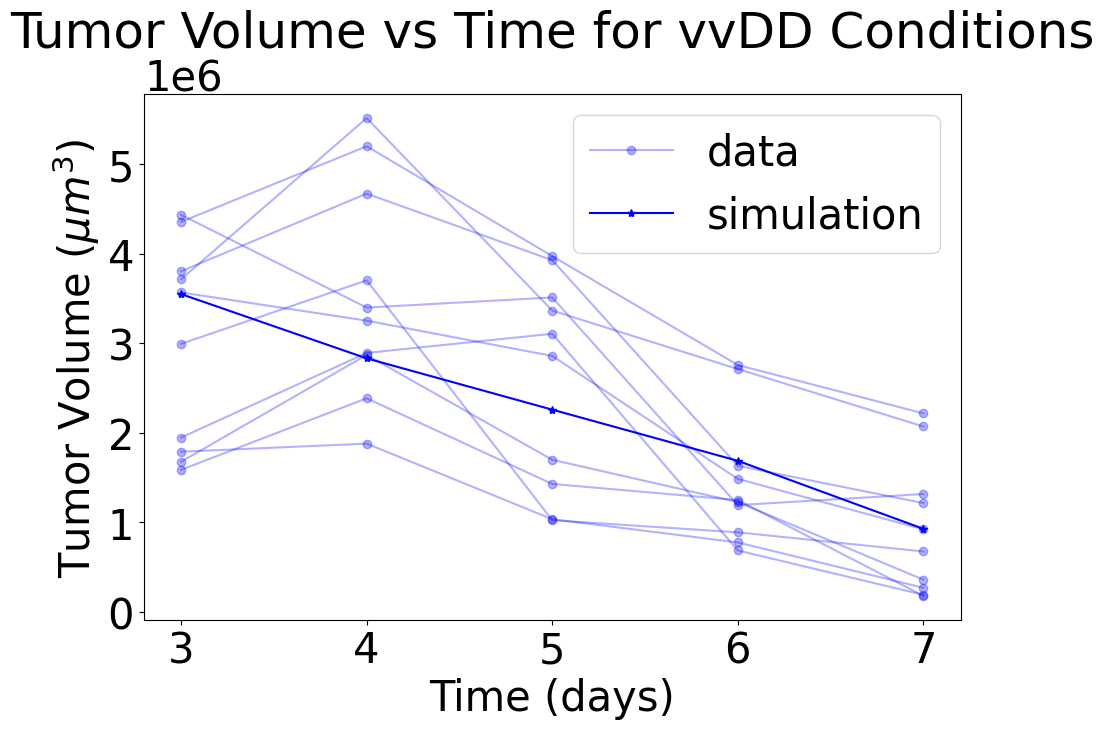

In [11]:
# plot the vvDD data and simulation, simulation[1] (1d array) and data[1] 
# (2d array as it has 5 timepoints [3,4,5,6,7] and 10 samples)
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.plot(np.array([3,4,5,6,7]), data[1][:, i], 
             marker='o', linestyle='-', color='blue', alpha=0.3, label='data' if i == 0 else "")
plt.plot(np.array([3,4,5,6,7]), simulation[1], 
         marker='*', linestyle='-', color='blue', alpha=1, label='simulation')
plt.xlabel('Time (days)')
plt.ylabel('Tumor Volume ($\mu m^3$)')
plt.title('Tumor Volume vs Time for vvDD Conditions')
plt.legend()
plt.grid(False)
plt.xticks([3, 4, 5, 6, 7])
plt.tight_layout()
plt.savefig(folder_path + 'vvDD_fit.pdf', dpi=300, bbox_inches='tight')
plt.show()

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2t/ydbb2dx16f3_f00v2ldb8_8m0000gn/T/ipykernel_69350/2267712599.py:16: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Tumor Volume ($\mu m^3$)')


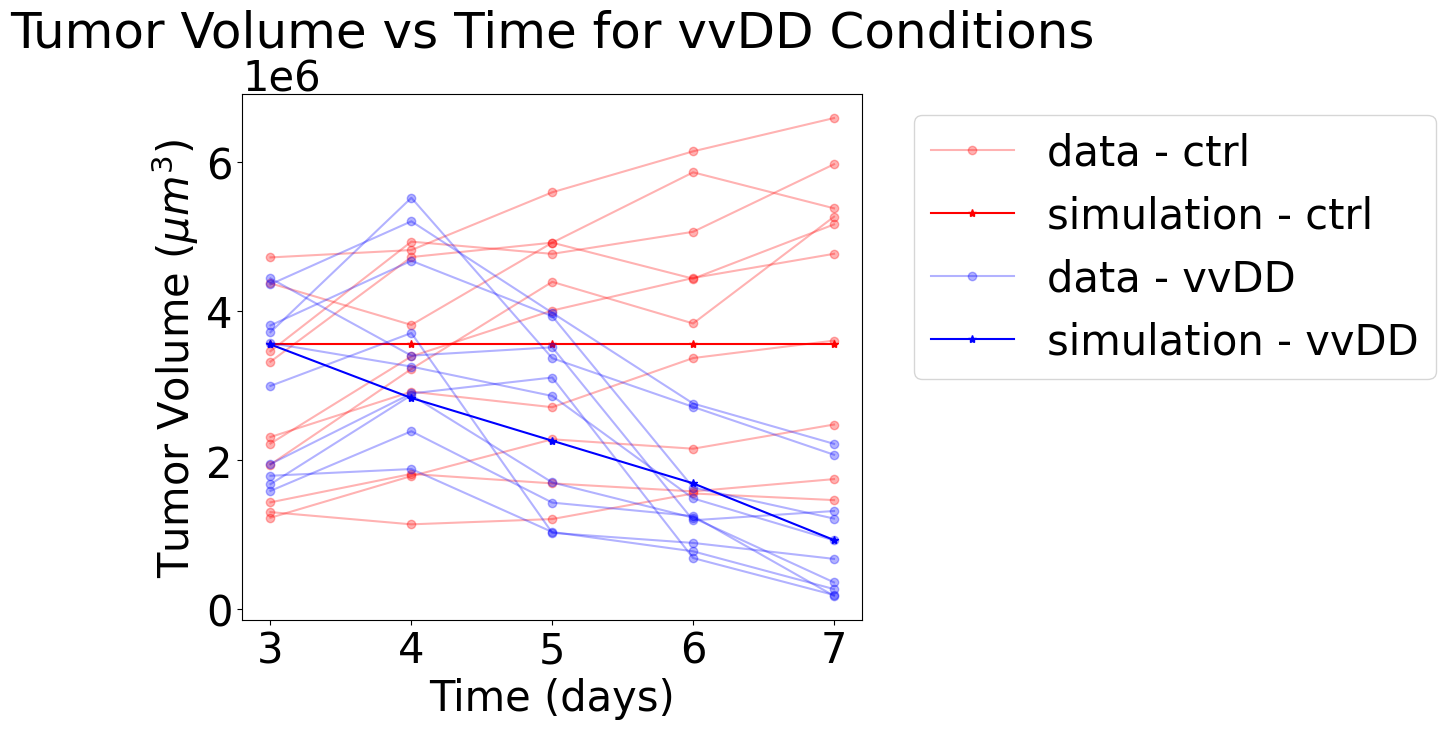

In [12]:
plt.figure(figsize=(14, 8))

for i in range(10):
    plt.plot(np.array([3,4,5,6,7]), data[0][:, i], 
             marker='o', linestyle='-', color='red', alpha=0.3, label='data - ctrl' if i == 0 else "")
plt.plot(np.array([3,4,5,6,7]), simulation[0], 
         marker='*', linestyle='-', color='red', alpha=1, label='simulation - ctrl')

for i in range(10):
    plt.plot(np.array([3,4,5,6,7]), data[1][:, i], 
             marker='o', linestyle='-', color='blue', alpha=0.3, label='data - vvDD' if i == 0 else "")
plt.plot(np.array([3,4,5,6,7]), simulation[1], 
         marker='*', linestyle='-', color='blue', alpha=1, label='simulation - vvDD')

plt.xlabel('Time (days)')
plt.ylabel('Tumor Volume ($\mu m^3$)')
plt.title('Tumor Volume vs Time for vvDD Conditions')
plt.legend()
plt.grid(False)
plt.xticks([3, 4, 5, 6, 7])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()
plt.savefig(folder_path + 'ctrl_vvDD_fit.pdf', dpi=300, bbox_inches='tight')
plt.show()

<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2t/ydbb2dx16f3_f00v2ldb8_8m0000gn/T/ipykernel_69350/924955907.py:26: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Tumor Volume ($\mu m^3$)')


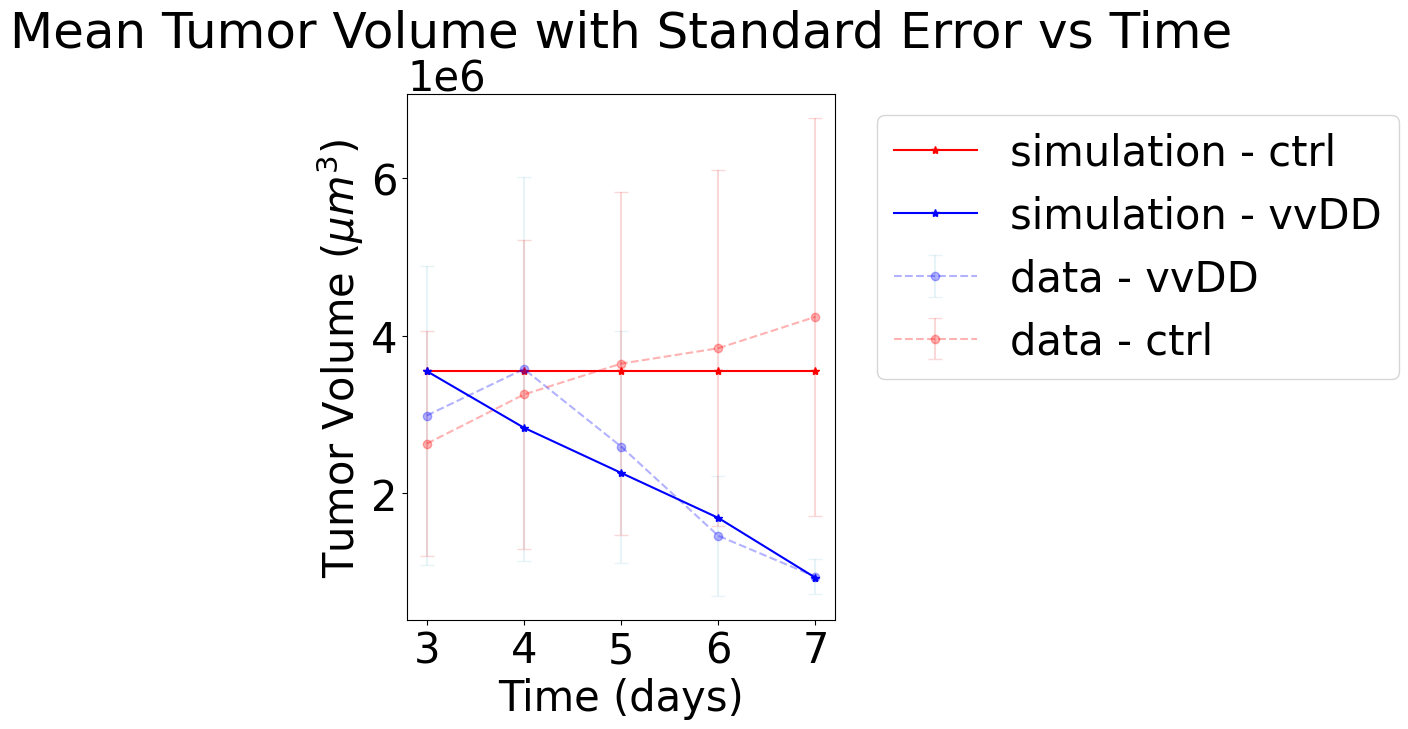

In [13]:
# calculate the mean and std of the data within ctrl and vvDD groups and compare again with the simulation

# Calculate mean and standard error for vvDD
vvDD_mean = data[1].mean(axis=1)
vvDD_se = data[1].std(axis=1)
# Calculate mean and standard error for PBS
pbs_mean = data[0].mean(axis=1)
pbs_se = data[0].std(axis=1)

# Plot both provided and calculated data
plt.figure(figsize=(12, 8))
# Plot provided data
plt.errorbar(np.array([3,4,5,6,7]), vvDD_mean, 
             yerr=[vvDD_mean - vvDD_se],
             fmt='o--', color='blue', alpha=0.3, ecolor='lightblue', capsize=5, label='data - vvDD')
plt.errorbar(np.array([3,4,5,6,7]), pbs_mean, 
             yerr=[pbs_mean - pbs_se],
             fmt='o--', color='red', alpha=0.3, ecolor='lightcoral', capsize=5, label='data - ctrl')
# Plot simulated data
plt.plot(np.array([3,4,5,6,7]), simulation[0], 
         marker='*', linestyle='-', color='red', alpha=1, label='simulation - ctrl')
plt.plot(np.array([3,4,5,6,7]), simulation[1], 
         marker='*', linestyle='-', color='blue', alpha=1, label='simulation - vvDD')

plt.xlabel('Time (days)')
plt.ylabel('Tumor Volume ($\mu m^3$)') 
plt.title('Mean Tumor Volume with Standard Error vs Time')
plt.legend()
plt.grid(False)
plt.xticks([3, 4, 5, 6, 7])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()
plt.savefig(folder_path + 'mean_tumor_volume_with_std_error.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Visualize Temporal Dynamics

In [14]:
1/(parameters_from_result['kappa'] + np.exp(-parameters_from_result['rho'] + np.log(1/(4 * 1E5) - parameters_from_result['kappa'])))

np.float64(-0.34177279761529783)

In [15]:
result.optimize_result.list[0]

{'id': '2',
 'x': array([ 2.12542548, -3.32257714, -1.95510146,  0.4728458 ,  1.52925705,
        -0.64547988,  0.95933635]),
 'fval': np.float64(1552.739046402772),
 'grad': array([-0.78150884, -1.10292283, -0.54995051,  0.62861577,  0.22515623,
         6.16589469, 18.27525127]),
 'hess': array([[ 1.21990400e+01,  4.00939814e+01,  1.20669234e+01,
         -1.03386466e+01, -3.15358251e+00,  3.57247929e+01,
         -3.59197821e+02],
        [ 4.00939814e+01,  2.80300146e+03,  3.61035056e+01,
         -3.34421539e+01, -1.07333952e+01,  2.71712365e+02,
         -1.10506158e+03],
        [ 1.20669234e+01,  3.61035056e+01,  1.21786306e+01,
         -1.02633048e+01, -3.09430046e+00,  3.31105449e+01,
         -3.60453463e+02],
        [-1.03386466e+01, -3.34421539e+01, -1.02633048e+01,
          8.76750375e+00,  2.66885389e+00, -2.99400846e+01,
          3.05196531e+02],
        [-3.15358251e+00, -1.07333952e+01, -3.09430046e+00,
          2.66885389e+00,  8.17839890e-01, -9.46614707e+00,
 

2024-09-13 16:22:51.036 - amici.swig_wrappers - DEBUG - [vvDD][CVODES:CVode:TOO_MUCH_WORK] AMICI ERROR: in module CVODES in function CVode : At t = 8.53731, mxstep steps taken before reaching tout. 
2024-09-13 16:22:51.039 - amici.swig_wrappers - ERROR - [vvDD][FORWARD_FAILURE] AMICI forward simulation failed at t = 8.53731: AMICI failed to integrate the forward problem


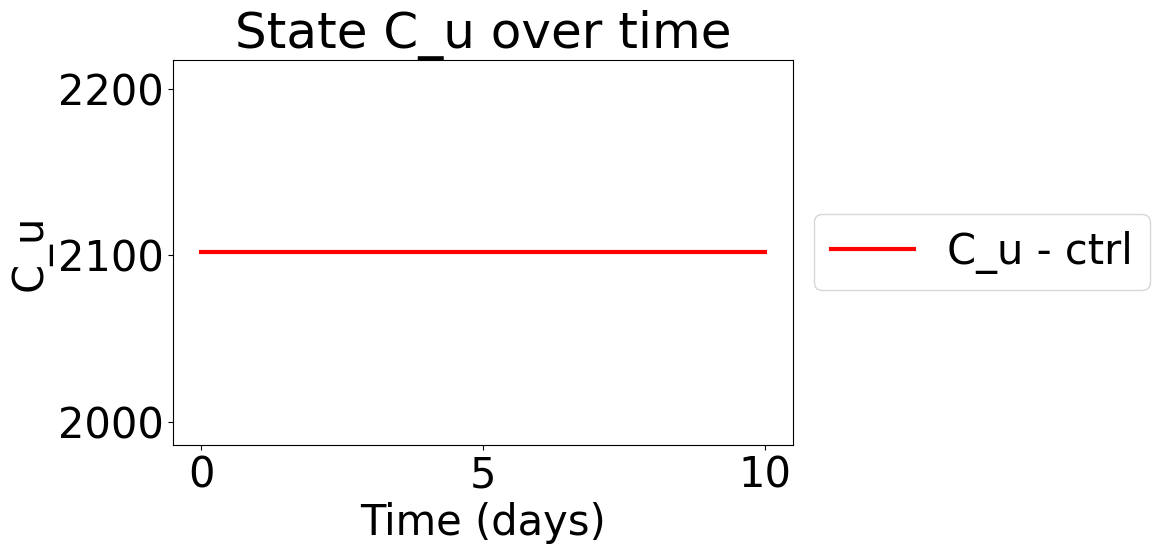

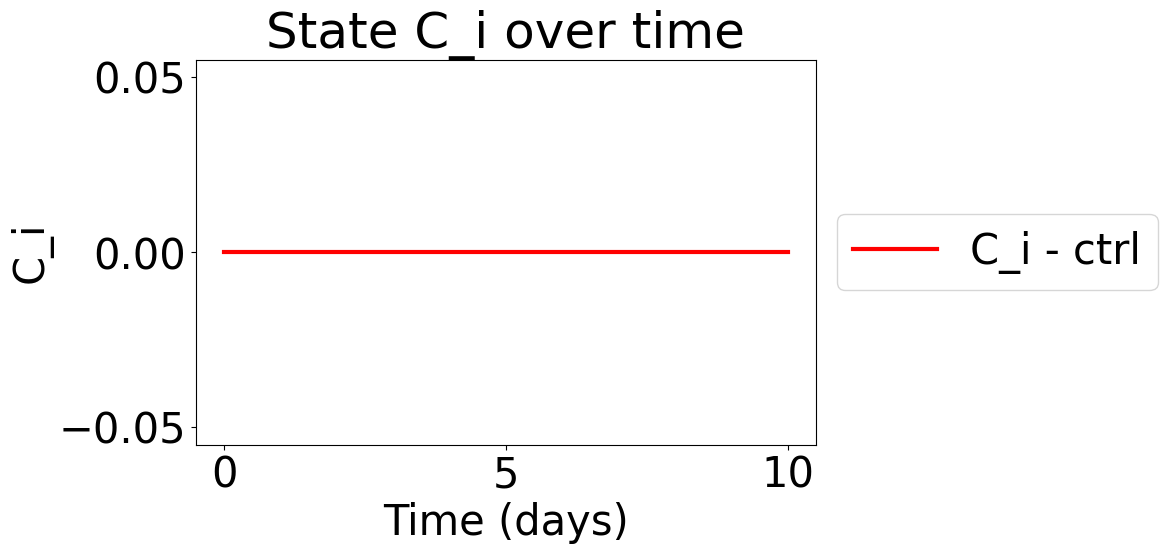

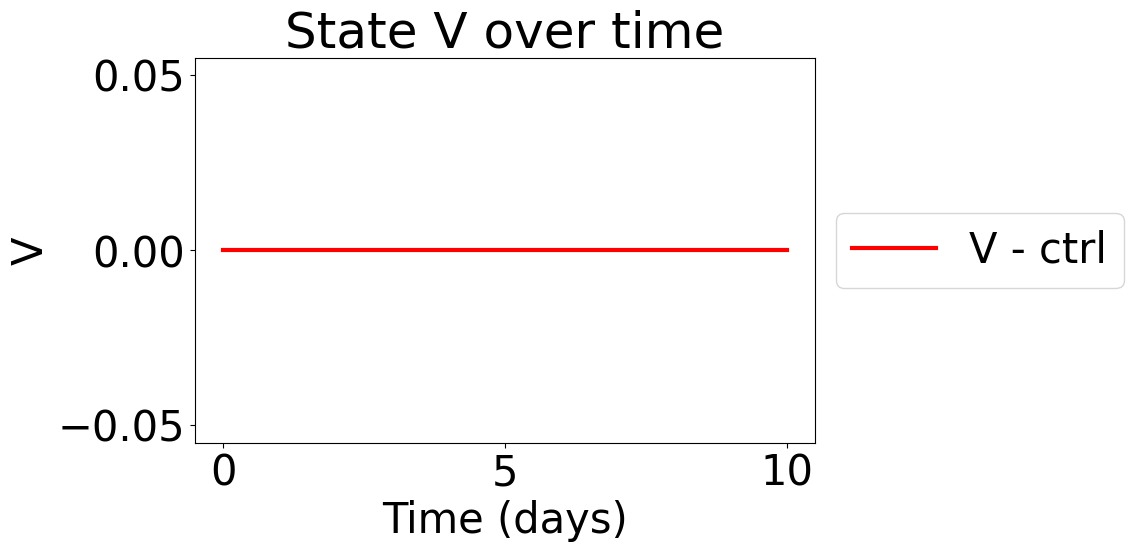

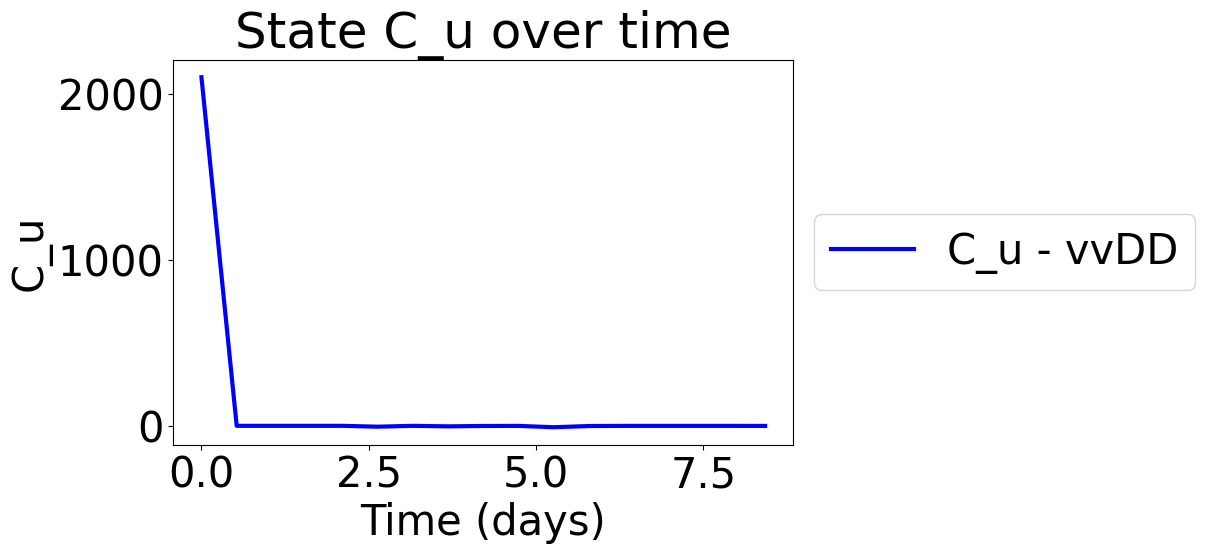

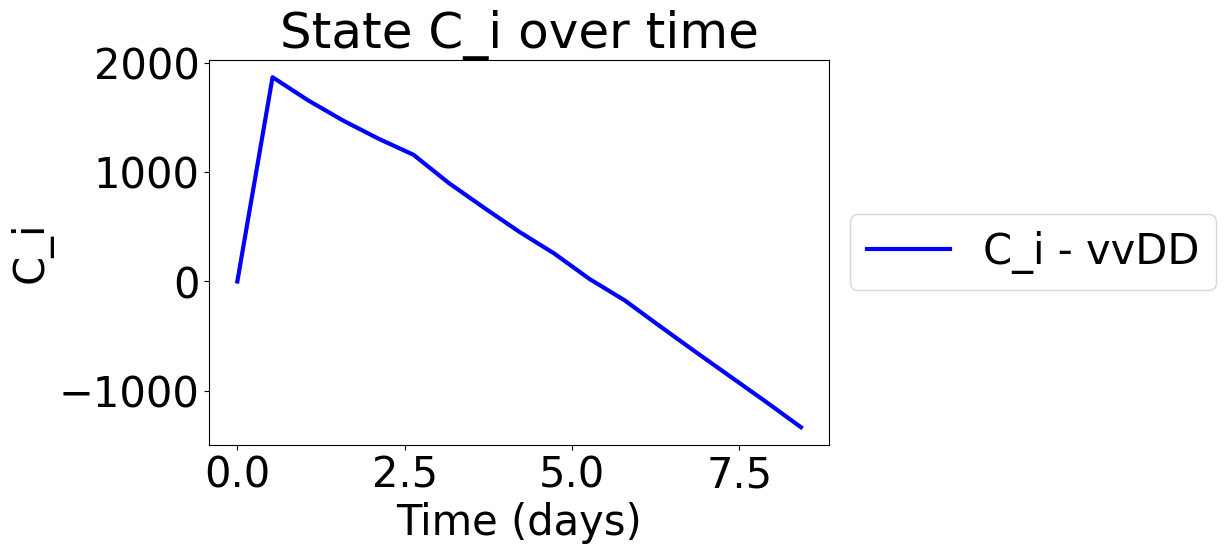

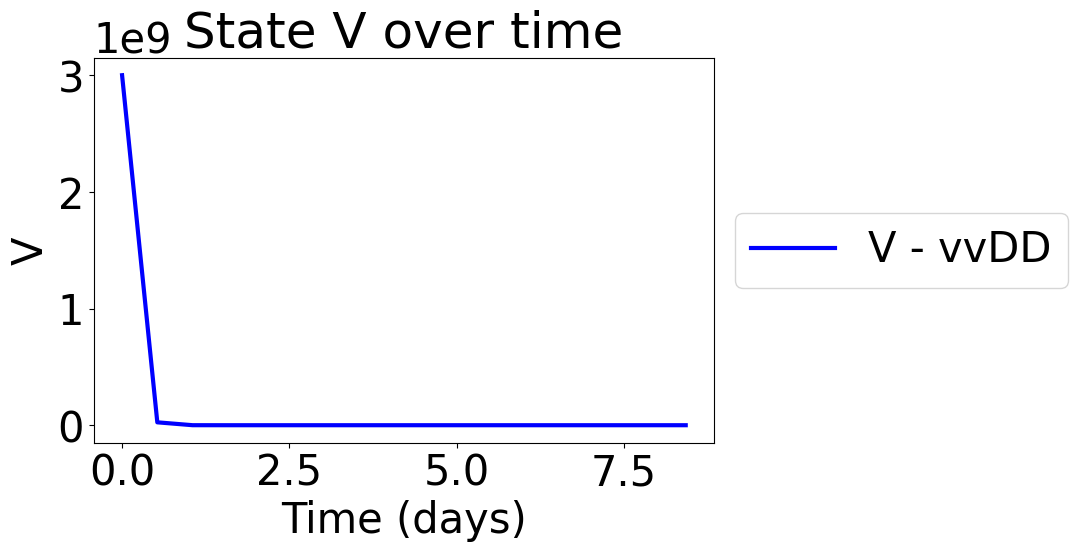

In [32]:
# visualize the temporal dynamics of the virus, uninfected and infected tumor cells using the fitted model from the result
# get the simulation results for the optimized parameters

from pypesto.visualize.model_fit import visualize_optimized_model_fit, _get_simulation_rdatas

amici_model = problem.objective.amici_model

species_to_plot = ['C_u', 'C_i', 'V']

# simulate from day 3 to day 12
timepoints = np.linspace(start=0, stop=10, num=20)

simulation_rdatas = _get_simulation_rdatas(
    result=result,
    problem=problem,
    start_index = 0,
    simulation_timepoints=timepoints,
)

# Plot all state trajectories
for c_ in range(len(problem.objective.edatas)):
    for species in species_to_plot:

        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        # for rdata, edata in zip(simulation_rdatas, problem.objective.edatas):
        label = f"{species} - {problem.objective.edatas[c_].id}"
        if problem.objective.edatas[c_].id == 'ctrl':
            ax.plot(timepoints, simulation_rdatas[c_]['x'][:, amici_model.getStateIds().index(species)], color='red', label=label, lw = 3)
        else:
            ax.plot(timepoints, simulation_rdatas[c_]['x'][:, amici_model.getStateIds().index(species)], color='blue', label=label, lw = 3)
        ax.set_ylabel(species)
        ax.set_xlabel('Time (days)')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title(f"State {species} over time")
        plt.savefig(folder_path + f"{species}_over_time.pdf", dpi=300, bbox_inches='tight')
        plt.show()

In [30]:
simulation_rdatas[c_]['x'][:, amici_model.getStateIds().index('C_u')]

array([ 2.10173106e+03, -1.93549626e-21, -2.23398704e-19,  8.33458633e-21,
        1.17493579e-19, -1.06433199e-18,  2.19996412e-16, -2.81242588e-17,
        6.86606281e-19, -1.70193267e-17, -9.84624538e-18,  2.48718565e-16,
        2.54512069e-18, -3.54093000e-16, -2.04499461e-17,  6.02397110e-16,
       -2.04477028e-15, -1.19074622e-14, -1.82109770e-13, -4.36698883e-12,
       -1.43448532e-10, -6.10099963e-09, -3.27527180e-07, -2.19055413e-05,
       -1.81050000e-03, -1.83426883e-01, -1.66130507e+01, -6.00691618e-02,
       -2.31185148e-02, -5.57854758e-01, -1.28696432e+01, -8.41368058e-02,
       -3.74023520e-01, -1.36812142e+01, -1.66324100e-01, -8.34948883e-01,
       -6.30456278e+00, -2.16061125e-01, -4.58144916e+00, -5.98762784e-01,
       -7.83199421e-01, -5.83394696e+00, -3.52983286e-01, -1.01069736e+01,
       -3.53689454e-01, -4.70758127e+00, -5.45593003e-01, -2.37425926e+00,
       -9.16650298e-01, -1.56470186e+00, -1.32751670e+00, -1.29994983e+00,
       -1.49781140e+00, -

In [ ]:
# TODO: check why the starting tumor volume is not the same as in the fitting plots
# TODO: add the C_u, C_i, V before the injection of virus
# TODO: correct x axis

# TODO: the dynamics after 5 days are below 0, which is not good - adjustment of the equations? 

# Parameter estimation analysis

In [ ]:
# get the statistics for 95% CI
cut_off_index = find_cut_off_index(result)
x_trace_within_cut_off = np.array(find_cut_off_x_trace(result, ci = 0.95))
x_trace_within_cut_off_df = pd.DataFrame(x_trace_within_cut_off, columns=problem.x_names)

x_trace_within_cut_off_NF = find_cut_off_x_trace(result, ci = 0.95, flatten=False)
x_trace_within_cut_off_NF_top100 = x_trace_within_cut_off_NF[:100]

# unpack and reshape x_trace_within_cut_off_NF_top100 into an array with the same column number as x_trace_within_cut
x_trace_within_cut_off_NF_top100_unpacked = []
for i in range(len(x_trace_within_cut_off_NF_top100)):
    for j in range(len(x_trace_within_cut_off_NF_top100[i])):
        x_trace_within_cut_off_NF_top100_unpacked.append(x_trace_within_cut_off_NF_top100[i][j])

x_trace_within_cut_off_NF_top100_unpacked_df = pd.DataFrame(x_trace_within_cut_off_NF_top100_unpacked, columns=problem.x_names)

In [ ]:
# TODO: visualize the virus, tumor and immune cells over time, meaning from day 2 to day 7
# TODO: visualize the parameter estimation results analysis
# TODO: adjust the capacity reaching the peak value timepoint, seems like now it is reaching too early
# QUESTION: but how to contraint it properly? based on just the data, all the simulation is within the error bar

# TODO: check the time shifting impact on the ODE systems, make sure the time shift is correctly implemented
# TODO: update overleaf documentation
# TODO: organize the notes in all papers
# TODO: Notion goals organzing

# TODO: mixed effects model exploration